<div style="text-align: left; background-color:black; font-family: Trebuchet MS; color:#A60505; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: black solid;"> Data Case Study: Used Car's price</div>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

## <div style="background-color:#B21010;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black">TABLE OF CONTENTS</div>   
    
* [1. INTRODUCTION](#1)
    
* [2. IMPORTING LIBRARIES](#2)
    
* [3. LOADING AND EXPLAINING DATASET](#3)
    * [3.1 Reading Dataset](#3.1)
    * [3.2 Create a Database for Metro and Non-Metro cities](#3.2)
    * [3.3 Read from Database](#3.3)
    * [3.4 Merge Dataframes](#3.4)
    
* [4. EXPLORATORY SOME INFORMATION ABOUT DATASET](#4)
    
    * [4.1. Basic Information About Dataset](#4.1)    
    * [4.2. Descriptive Statistics of Dataset](#4.2)    
    * [4.3. Other Basic Information about Dataset](#4.3)
    * [4.4. Correlation between Variables of Dataset](#4.4)
    
* [5. PREPROCESSING DATASET](#5)

* [6. DATA VISUALIZATION](#6)
    
* [7. MACHINE LEARNING](#7)
 


<a id="1"></a>
## <b>1 <span style='color:#B21010'>||</span> INTRODUCTION</b>
<hr>
<p>
    Most of the people want to buy a vehicle for themselves but there are some who could not afford to buy a brand new car so instead they purchase used car. There are many platforms that are helping these customers in realizing their dreams. <code>One person's garbage can be fortune to other person</code>.<br>
    Through this code I will be trying to find the best ML algorithm<br>
    Dataset that I'm using can be found <a href='https://www.kaggle.com/datasets/avikasliwal/used-cars-price-prediction'>here</a>
</p>

<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span> IMPORTING LIBRARIES</b>

In [1]:
import numpy as np
import os
import pandas as pd
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as mno
import warnings
warnings.filterwarnings("ignore")

<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> LOADING AND EXPLAINING DATASET</b>

<a id="3.1"></a>
#### <b>3.1 <span style='color:#B21010'>|</span> Loading Dataset

In [2]:
# load the training dataset
train = pd.read_csv('datasets/train-data.csv')
train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


<a id="3.2"></a>
#### <b>3.2 <span style='color:#B21010'>|</span> Create a Database for Metro and Non-Metro cities

In [3]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return conn

In [4]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [5]:
def insert_entry(conn, data):
    """
    Create a new task
    :param conn:
    :param data:
    :return:
    """

    sql = ''' INSERT INTO cities(id, name, is_metro)
              VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, data)
    conn.commit()
    return cur.lastrowid

In [6]:
database = r'datasets/cities_db.db'
os.remove(database)
sql_create_cities_table = """ CREATE TABLE IF NOT EXISTS cities (
                                    id integer PRIMARY KEY,
                                    name text NOT NULL,
                                    is_metro BOOLEAN NOT NULL CHECK (is_metro IN (0, 1))
                                ); """

# create a database connection
conn = create_connection(database)

# create tables
if conn is not None:
    # create cities table
    create_table(conn, sql_create_cities_table)
    locations = { i: (1 if i in ['Mumbai', 'Delhi', 'Kolkata', 'Chennai'] else 0) for i in train['Location'].unique()}
    for idx, key in zip(range(len(locations.keys())),list(locations.keys())):
        data = (idx, key, locations[key])
        insert_entry(conn, data)


else:
    print("Error! cannot create the database connection.")

<a id="3.3"></a>
#### <b>3.3 <span style='color:#B21010'>|</span> Read from Database

In [7]:
engine = create_engine('sqlite:///%s'%database)
with engine.connect() as con:
    rs = con.execute('Select id, name, is_metro from cities')
    df = pd.DataFrame(rs.fetchall())
    df.columns = rs.keys()
    
df.head()

,id,name,is_metro
0,0,Mumbai,1
1,1,Pune,0
2,2,Chennai,1
3,3,Coimbatore,0
4,4,Hyderabad,0


<a id="3.4"></a>
#### <b>3.4 <span style='color:#B21010'>|</span> Merge Dataframes

In [8]:
columns = train.columns
print(columns)
train = pd.merge(train, df, how="inner", left_on="Location", right_on="name")
train = train[[*columns, 'is_metro']]
train.head()

Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
       'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
       'Seats', 'New_Price', 'Price'],
      dtype='object')


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,is_metro
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75,1
1,7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,8.0,21 Lakh,17.50,1
2,22,Audi A6 2011-2015 35 TFSI Technology,Mumbai,2015,55985,Petrol,Automatic,First,13.53 kmpl,1984 CC,177.01 bhp,5.0,NaN,23.50,1
3,25,Honda City Corporate Edition,Mumbai,2012,51920,Petrol,Manual,First,16.8 kmpl,1497 CC,116.3 bhp,5.0,NaN,4.25,1
4,29,Toyota Innova 2.5 V Diesel 7-seater,Mumbai,2007,262000,Diesel,Manual,Fourth & Above,12.8 kmpl,2494 CC,102 bhp,7.0,NaN,4.00,1


<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> EXPLORATORY SOME INFORMATION ABOUT DATASET</b>

<a id="4.1"></a>
#### <b>4.1 <span style='color:#B21010'>|</span> Basic Information About Dataset

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
 14  is_metro           6019 non-null   int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 752.4+ KB


<a id="4.2"></a>
#### <b>4.2 <span style='color:#B21010'>|</span> Descriptive Statistics of Dataset

In [10]:
train.describe().T.style.set_properties(**{"background-color": "#FBA7A7", "font-size" : "17px",
                                        "color": "#ffffff", "border-radius" : "1px", "border": "1.5px solid black"})

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,6019.000000,3009.000000,1737.679967,0.000000,1504.500000,3009.000000,4513.500000,6018.000000
Year,6019.000000,2013.358199,3.269742,1998.000000,2011.000000,2014.000000,2016.000000,2019.000000
Kilometers_Driven,6019.000000,58738.380296,91268.843206,171.000000,34000.000000,53000.000000,73000.000000,6500000.000000
Seats,5977.000000,5.278735,0.808840,0.000000,5.000000,5.000000,5.000000,10.000000
Price,6019.000000,9.479468,11.187917,0.440000,3.500000,5.640000,9.950000,160.000000
is_metro,6019.000000,0.394252,0.488730,0.000000,0.000000,0.000000,1.000000,1.000000


<a id="4.3"></a>
#### <b>4.3 <span style='color:#B21010'>|</span> Other Basic Information about Dataset

Shape of the dataset:  (6019, 15)
_______________________________________
Number of null values: 
Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
is_metro                0
dtype: int64
_______________________________________
Number of unique values: 
Unnamed: 0           6019
Name                 1876
Location               11
Year                   22
Kilometers_Driven    3093
Fuel_Type               5
Transmission            2
Owner_Type              4
Mileage               442
Engine                146
Power                 372
Seats                   9
New_Price             540
Price                1373
is_metro                2
dtype: int64


<AxesSubplot:>

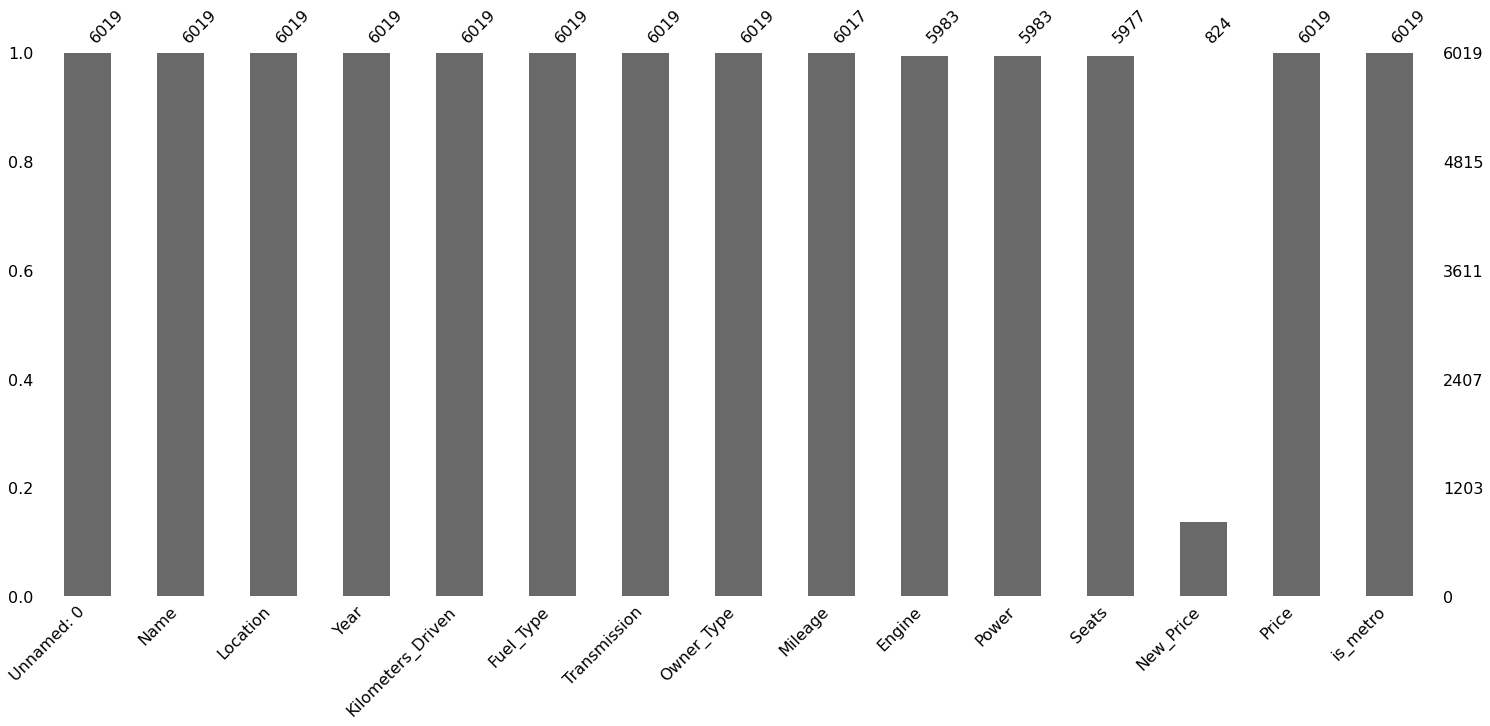

In [11]:
print("Shape of the dataset: ", train.shape)
print("_______________________________________")
print("Number of null values: ")
print(train.isnull().sum())
print("_______________________________________")
print("Number of unique values: ")
print(train.nunique())

mno.bar(train)

The `New_price` and `Unnamed` columns can be deleted as they either contains very large missing values or have no significance

<a id="4.4"></a>
#### <b>4.4 <span style='color:#B21010'>|</span> Correlation between Variables of Dataset

In [12]:
corr=train.corr()
corr.style.background_gradient(cmap='Reds')

,Unnamed: 0,Year,Kilometers_Driven,Seats,Price,is_metro
Unnamed: 0,1.000000,0.002354,-0.008734,-0.010832,-0.020275,-0.002292
Year,0.002354,1.000000,-0.173048,0.012333,0.305327,-0.097433
Kilometers_Driven,-0.008734,-0.173048,1.000000,0.083113,-0.011493,-0.015539
Seats,-0.010832,0.012333,0.083113,1.000000,0.052225,0.001938
Price,-0.020275,0.305327,-0.011493,0.052225,1.000000,-0.085350
is_metro,-0.002292,-0.097433,-0.015539,0.001938,-0.085350,1.000000


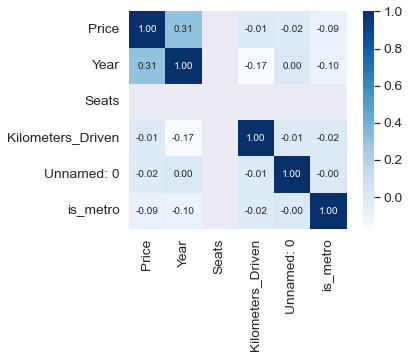

In [13]:
k=8
corrmat = train.corr()
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values,cmap="Blues")
plt.show()

<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span> PREPROCESSING DATASET</b>

In [14]:
# remove insignificant features
train.drop(['Unnamed: 0', 'New_Price'], axis=1, inplace=True)
train

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,is_metro
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,1
1,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,8.0,17.50,1
2,Audi A6 2011-2015 35 TFSI Technology,Mumbai,2015,55985,Petrol,Automatic,First,13.53 kmpl,1984 CC,177.01 bhp,5.0,23.50,1
3,Honda City Corporate Edition,Mumbai,2012,51920,Petrol,Manual,First,16.8 kmpl,1497 CC,116.3 bhp,5.0,4.25,1
4,Toyota Innova 2.5 V Diesel 7-seater,Mumbai,2007,262000,Diesel,Manual,Fourth & Above,12.8 kmpl,2494 CC,102 bhp,7.0,4.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Hyundai i20 1.4 Sportz,Ahmedabad,2018,30000,Diesel,Manual,First,22.54 kmpl,1396 CC,88.73 bhp,5.0,7.75,0
6015,Maruti Esteem Vxi - BSIII,Ahmedabad,2005,81000,Petrol,Manual,Second,15.9 kmpl,1298 CC,85 bhp,5.0,0.75,0
6016,Mercedes-Benz C-Class Progressive C 220d,Ahmedabad,2019,4000,Diesel,Automatic,First,0.0 kmpl,1950 CC,194 bhp,5.0,35.00,0
6017,Maruti Alto K10 VXI AGS,Ahmedabad,2017,20000,Petrol,Automatic,First,24.07 kmpl,998 CC,67.1 bhp,5.0,4.00,0


The dataset contains two different metric system we can either convert them to same metric system or they are erroneous records which can be skipped. Judging from the data it seems like the records are errors and can be overlooked.

In [15]:
# list comprehension and regex
import re
index = [idx for idx, i in enumerate(train.Mileage) if re.search('km/kg', str(i))]
# index

In [16]:
# using numpy array to check if any Mileage system based on km/kg has value other than LPG or CNG
arr = train.iloc[index].to_numpy()
for i in arr:
    if not np.any(['LPG','CNG'] not in i):
        print(i)

In [17]:
##train.drop(index, axis=0, inplace=True)
#train

In [18]:
train.Engine.fillna('0 CC',inplace=True)
for i in range(len(train.Engine)):
    val=train.Engine.iloc[i]
    cc=val.split(' ')
    train.Engine.iloc[i]=cc[0]
train.Engine=train.Engine.astype('int64')

In [19]:
train.Fuel_Type.value_counts()
Mileage_value=list()
Mileage_unit=list()
# since electric vehicles can be identified with the indicator that mileage is empty
# putting a unique value for the nan values, or outliers

train.Mileage.fillna(value='-1 kmpl',inplace=True)
for i in range(len(train.Mileage)):
    val=train.Mileage.iloc[i]
    cc=val.split(' ')
    train.Mileage.iloc[i]=cc[0]
    Mileage_value.append(cc[0])
    Mileage_unit.append(cc[1])

In [20]:
train.Mileage=train.Mileage.astype('float64')

den_petrol=0.8
den_diesel=0.85  # in kg/l
count=0

for i in range(len(Mileage_unit)):
    if((Mileage_unit[i]=='kmpl') and (train.Fuel_Type.iloc[i]=='Petrol')):
        train.Mileage.iloc[i]=train.Mileage.iloc[i]/den_petrol 
    elif((Mileage_unit[i]=='kmpl') and (train.Fuel_Type.iloc[i]=='Diesel')):
        train.Mileage.iloc[i]= train.Mileage.iloc[i]/den_diesel

In [21]:
# converting column types using a customised function
def clean_data(df, col_name, **kwargs):
    kwargs = {'replace_values': dict(), 'dtype': float, **kwargs}
    keys = list(kwargs['replace_values'].keys())
    values = list(kwargs['replace_values'].values())
    df[col_name] = df[col_name].str.replace(keys[0], values[0]).replace(keys[1], values[1]).astype(kwargs['dtype'])
    kwargs = {'na_values':df[col_name].median(), **kwargs}
    df[col_name] = df[col_name].fillna(kwargs['na_values'])
    return df[col_name]
    
# train['Mileage']=clean_data(train, col_name='Mileage', replace_values={' kmpl':'', 'null':0})
# train['Mileage'].str.replace(' kmpl','').replace('null',0)
# train['Engine']=clean_data(train, col_name='Engine', replace_values={' CC':'', 'null':0}, dtype='int64')
# train['Engine'].str.replace(' CC','').replace('null',0)
train['Power']=clean_data(train, col_name='Power', replace_values={' bhp':'', 'null':0})
# train['Power'].str.replace(' bhp','').replace('null',0)
train['Seats']=train['Seats'].fillna(train['Seats'].median())

In [22]:
train = (train.reset_index()).drop('index', axis=1)
train

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,is_metro
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.600000,998,58.16,5.0,1.75,1
1,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,13.364706,2755,171.50,8.0,17.50,1
2,Audi A6 2011-2015 35 TFSI Technology,Mumbai,2015,55985,Petrol,Automatic,First,16.912500,1984,177.01,5.0,23.50,1
3,Honda City Corporate Edition,Mumbai,2012,51920,Petrol,Manual,First,21.000000,1497,116.30,5.0,4.25,1
4,Toyota Innova 2.5 V Diesel 7-seater,Mumbai,2007,262000,Diesel,Manual,Fourth & Above,15.058824,2494,102.00,7.0,4.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Hyundai i20 1.4 Sportz,Ahmedabad,2018,30000,Diesel,Manual,First,26.517647,1396,88.73,5.0,7.75,0
6015,Maruti Esteem Vxi - BSIII,Ahmedabad,2005,81000,Petrol,Manual,Second,19.875000,1298,85.00,5.0,0.75,0
6016,Mercedes-Benz C-Class Progressive C 220d,Ahmedabad,2019,4000,Diesel,Automatic,First,0.000000,1950,194.00,5.0,35.00,0
6017,Maruti Alto K10 VXI AGS,Ahmedabad,2017,20000,Petrol,Automatic,First,30.087500,998,67.10,5.0,4.00,0


In [23]:
# Post cleansing
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6019 non-null   float64
 8   Engine             6019 non-null   int64  
 9   Power              6019 non-null   float64
 10  Seats              6019 non-null   float64
 11  Price              6019 non-null   float64
 12  is_metro           6019 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 611.4+ KB


In [24]:
visual_data=pd.DataFrame()
for i in range(train.shape[0]):
    visual_data.at[i, 'Company'] = train['Name'][i].split()[0].upper()
    visual_data.at[i, 'Mileage'] = float(str(train['Mileage'][i]).split()[0])
    visual_data.at[i, 'Engine'] = float(str(train['Engine'][i]).split()[0])
    visual_data.at[i, 'Power'] = float(str(train['Power'][i]).split()[0])
    visual_data.at[i, 'Price'] = float(str(train['Price'][i]).split()[0])
    visual_data.at[i, 'Location'] = train['Location'][i]
    visual_data.at[i, 'is_metro'] = 'Y' if train['is_metro'][i] == 1 else 'N'
visual_data

,Company,Mileage,Engine,Power,Price,Location,is_metro
0,MARUTI,26.600000,998.0,58.16,1.75,Mumbai,Y
1,TOYOTA,13.364706,2755.0,171.50,17.50,Mumbai,Y
2,AUDI,16.912500,1984.0,177.01,23.50,Mumbai,Y
3,HONDA,21.000000,1497.0,116.30,4.25,Mumbai,Y
4,TOYOTA,15.058824,2494.0,102.00,4.00,Mumbai,Y
...,...,...,...,...,...,...,...
6014,HYUNDAI,26.517647,1396.0,88.73,7.75,Ahmedabad,N
6015,MARUTI,19.875000,1298.0,85.00,0.75,Ahmedabad,N
6016,MERCEDES-BENZ,0.000000,1950.0,194.00,35.00,Ahmedabad,N
6017,MARUTI,30.087500,998.0,67.10,4.00,Ahmedabad,N


<a id="6"></a>
## <b>6 <span style='color:#B21010'>||</span> DATA VISUALIZATION</b>

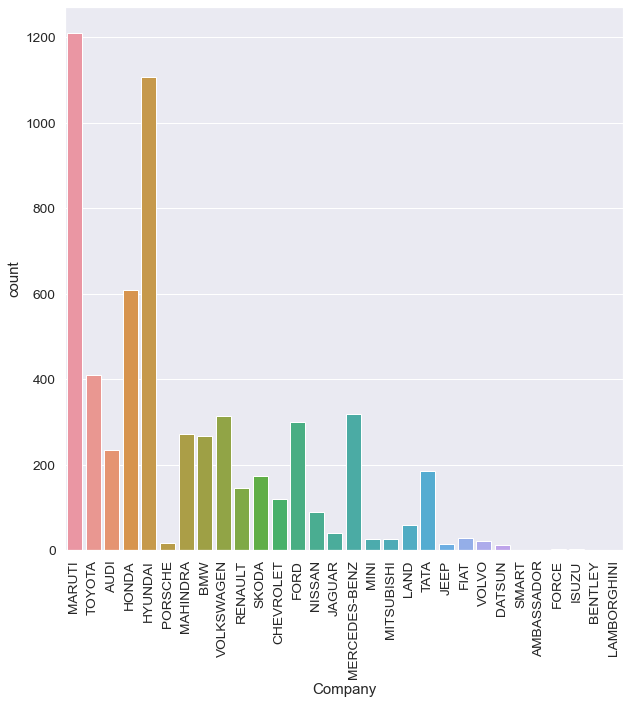

In [25]:
# Based on company
plt_data = visual_data['Company']
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,1,1)
ax = sns.countplot(x=plt_data.index, data=plt_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

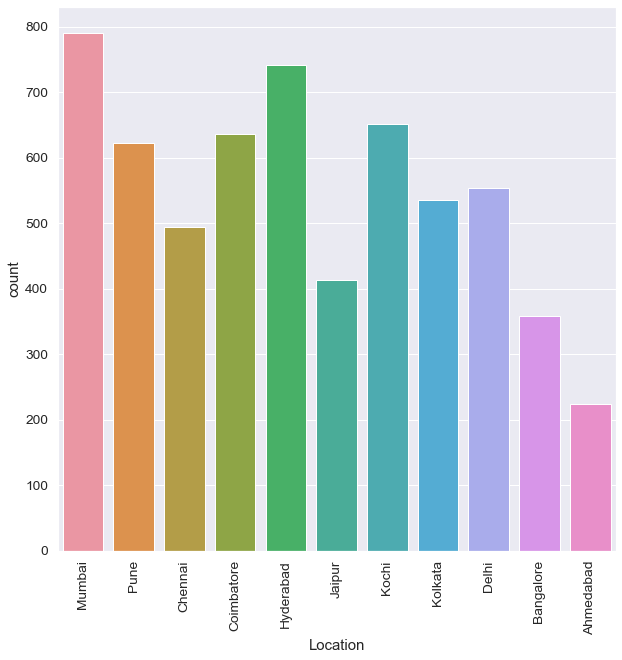

In [26]:
# Based on Location
plt_data = visual_data['Location']
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,1,1)
ax = sns.countplot(x=plt_data.index, data=plt_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [27]:
def diagnostic_plots(train_notnull, variable, target):
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 4, 1)
    sns.histplot(train_notnull[variable], bins=30, color = 'r')
    plt.title('Histogram')

    plt.subplot(1, 4, 2)
    plt.scatter(train_notnull[variable],train_notnull['Price'],color = 'g')
    plt.title('Scatterplot')

    plt.subplot(1, 4, 3)
    sns.boxplot(y=train_notnull[variable],color = 'b')
    plt.title('Boxplot')

    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = train_notnull)   
    plt.title('Barplot')

    plt.show()

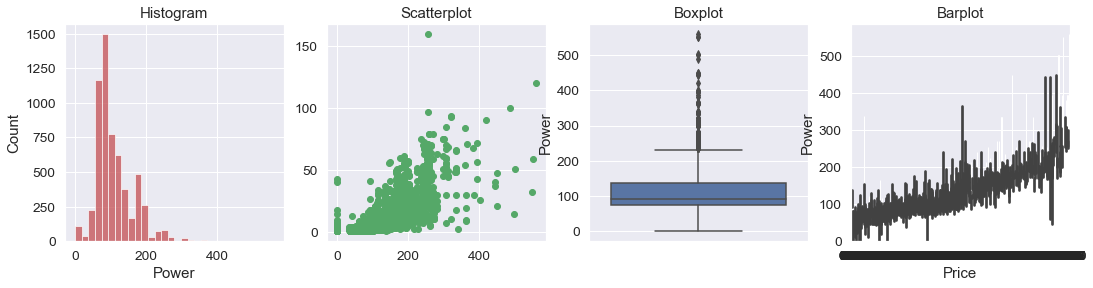

In [28]:
diagnostic_plots(train, 'Power','Price')

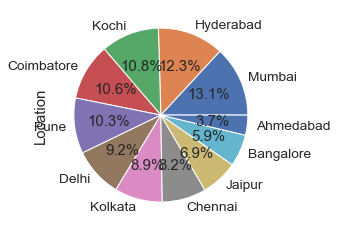

In [29]:
train['Location'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

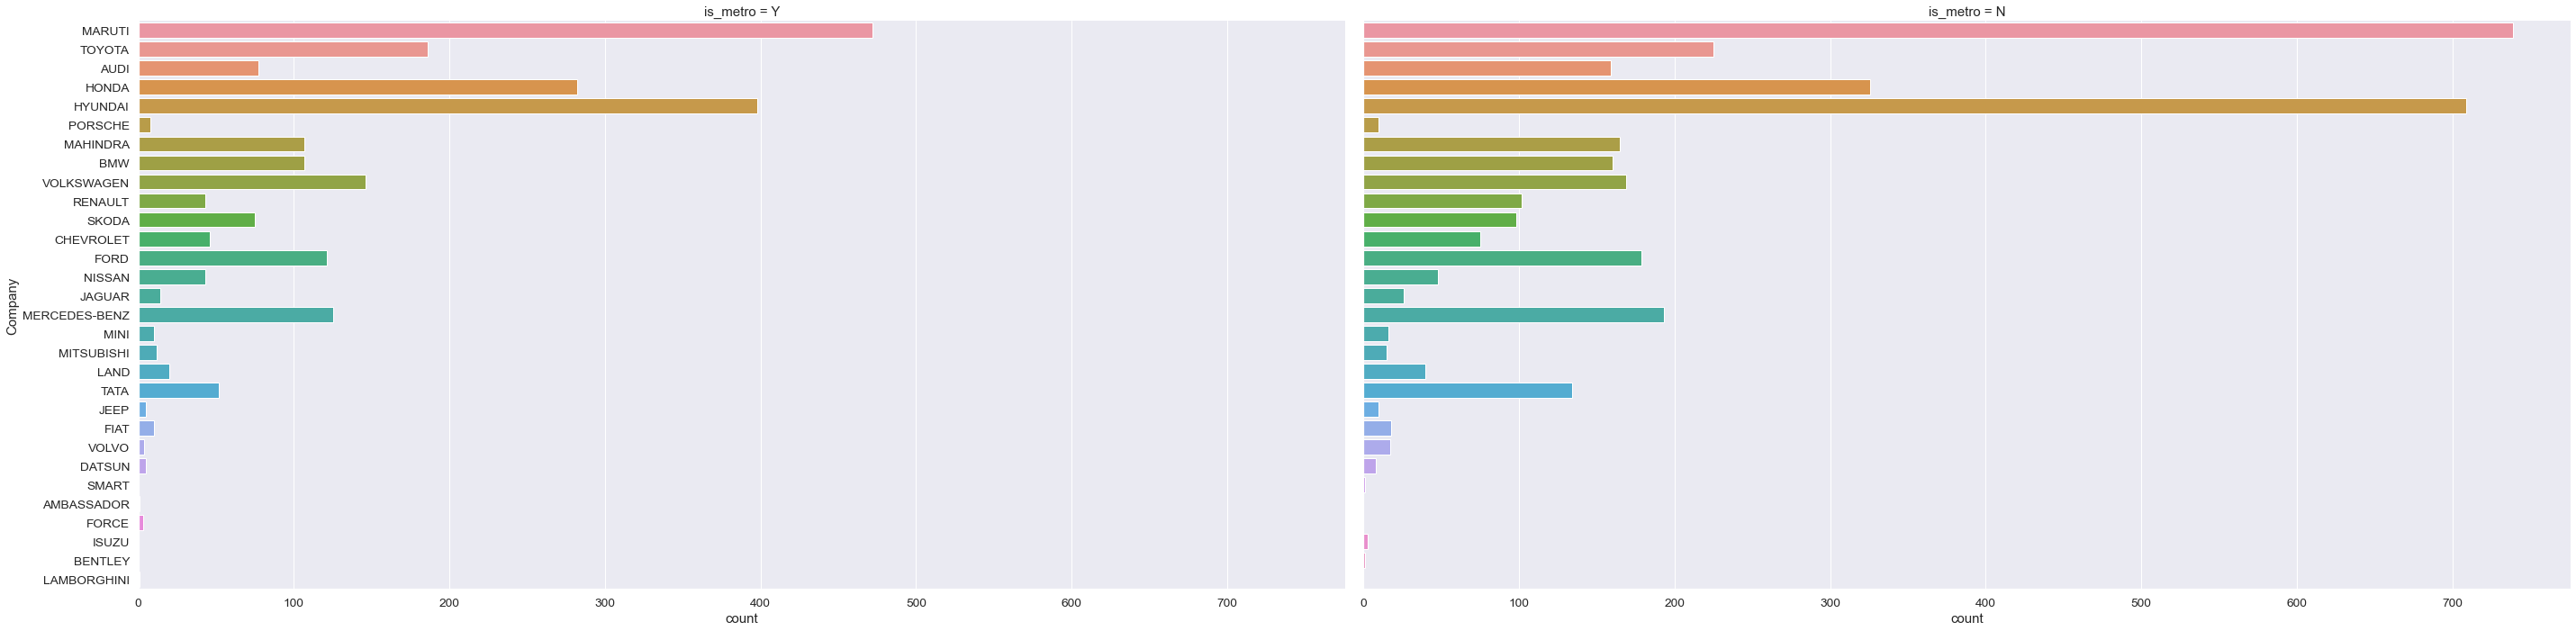

In [30]:
# Separate into column subplots based on Metro/Non-metro category
sns.catplot(y="Company", data=visual_data,
            kind="count",
            col="is_metro",
            height=10, aspect=2)

# Show plot
plt.show()

<AxesSubplot:xlabel='Owner_Type', ylabel='Kilometers_Driven'>

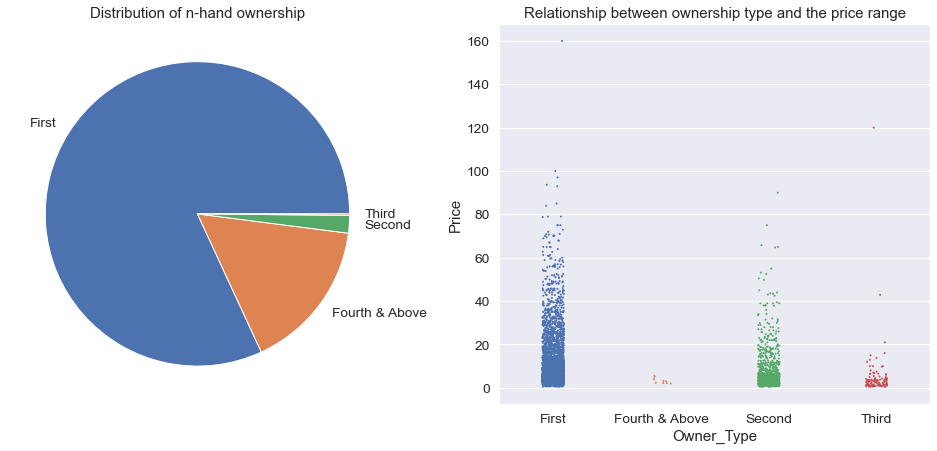

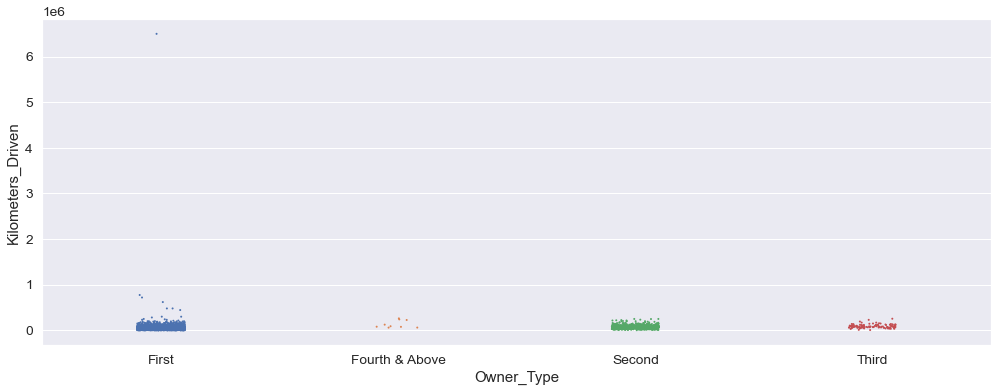

In [31]:
fig,ax=plt.subplots(1,2)
fig.set_figwidth(17)
fig.set_figheight(7)
ax[0].pie(list(train.Owner_Type.value_counts()),labels=train.Owner_Type.unique())
ax[0].set_title("Distribution of n-hand ownership")
sns.stripplot(x='Owner_Type',y='Price',data=train,ax=ax[1],size=2)
ax[1].set_title("Relationship between ownership type and the price range")

plt.figure(figsize=[17,6])
sns.stripplot(x='Owner_Type',y='Kilometers_Driven',data=train,size=2)

Text(0.5, 1.0, 'Prices of the cars over the years')

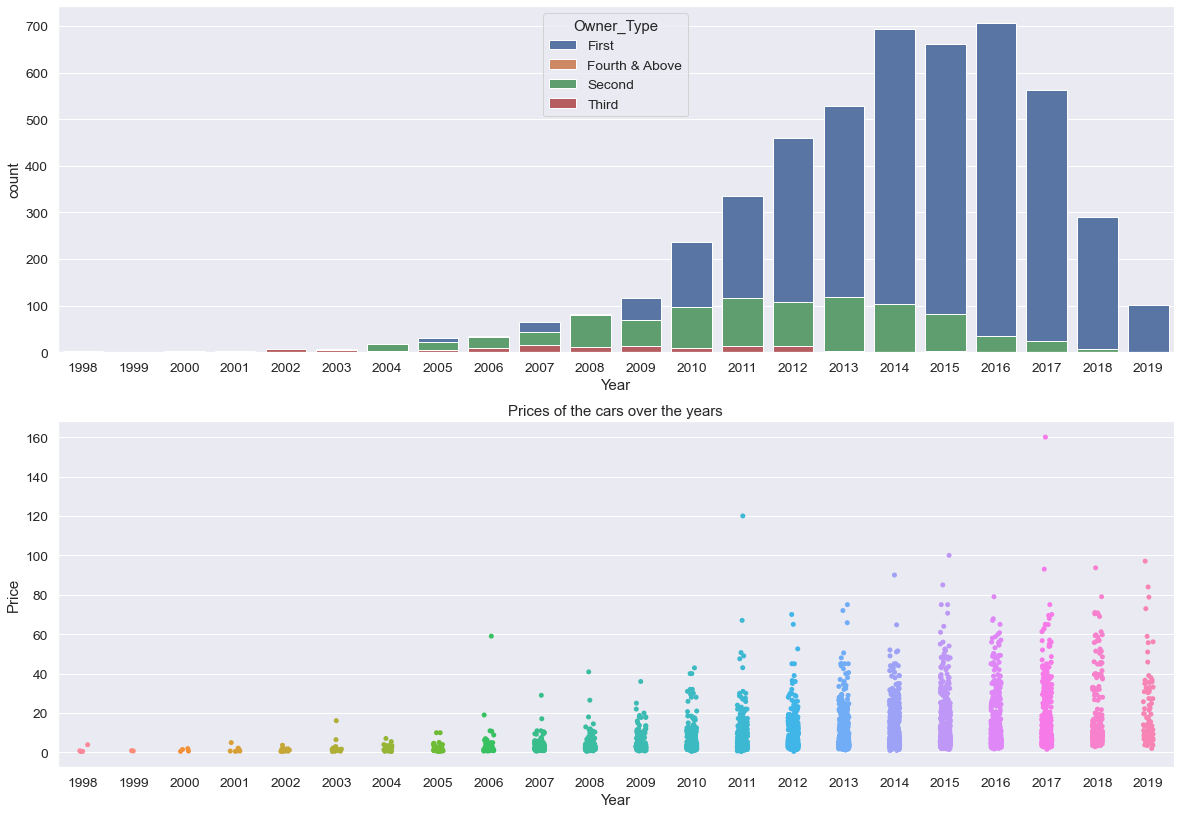

In [32]:
plt.figure(figsize=[20,14])
plt.subplot(2,1,1)
sns.countplot(x='Year',data=train,hue='Owner_Type',dodge=False)
plt.subplot(2,1,2)
sns.stripplot(x='Year',data=train,y='Price')
plt.title("Prices of the cars over the years")

<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span> Machine Learning</b>

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
obj_cols = [col for col in train.columns if train[col].dtype=='object']
obj_cols.remove('Name')

<AxesSubplot:>

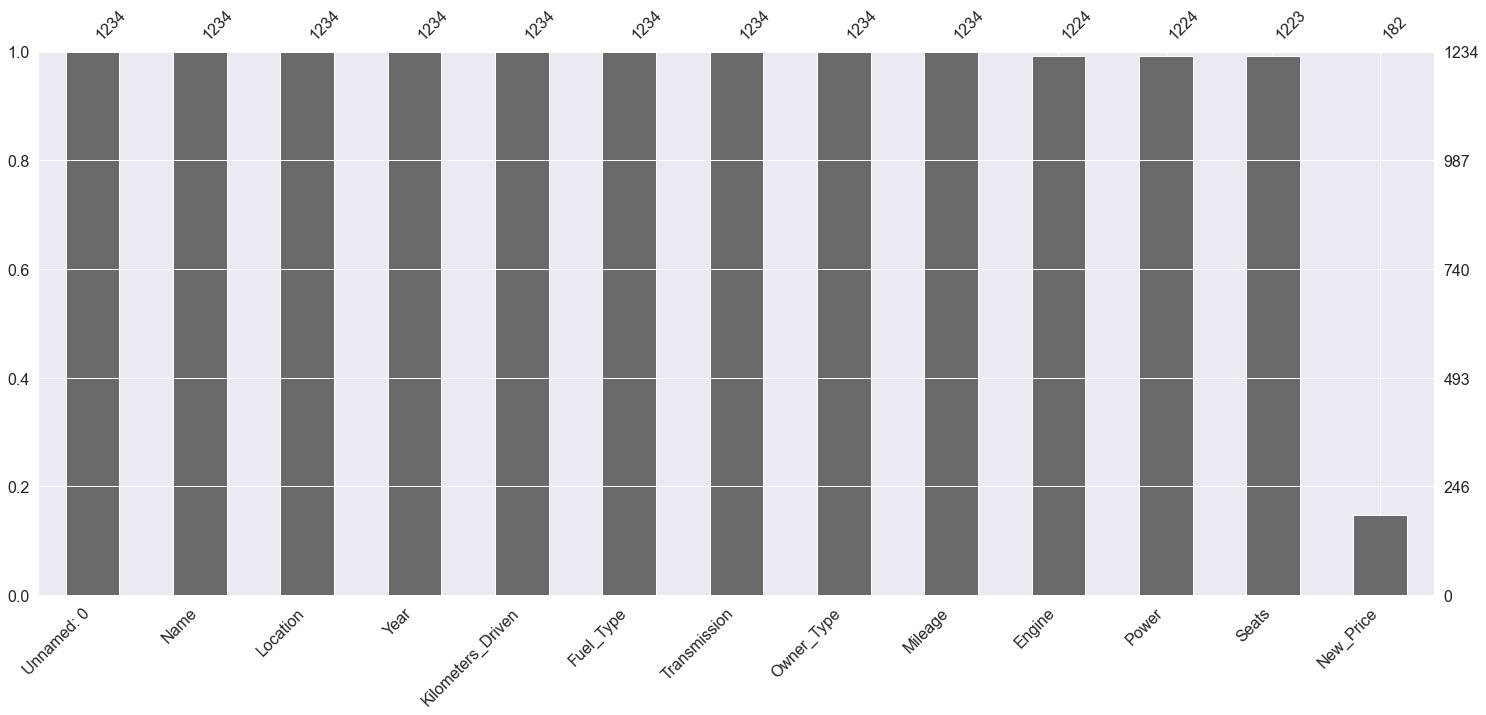

In [35]:
test = pd.read_csv('datasets/test-data.csv')
mno.bar(test)

In [36]:
# remove insignificant features
test.drop(['Unnamed: 0', 'New_Price'], axis=1, inplace=True)
# test = test[['Fuel_Type', 'Transmission', 'Owner_Type']]
test

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0
1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0
2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0
3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,null bhp,5.0
4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0
...,...,...,...,...,...,...,...,...,...,...,...
1229,Volkswagen Vento Diesel Trendline,Hyderabad,2011,89411,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0
1230,Volkswagen Polo GT TSI,Mumbai,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197 CC,103.6 bhp,5.0
1231,Nissan Micra Diesel XV,Kolkata,2012,28000,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0
1232,Volkswagen Polo GT TSI,Pune,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197 CC,103.6 bhp,5.0


In [37]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in obj_cols:
    train[col]=le.fit_transform(train[col])
    test[col]=le.transform(test[col])



In [38]:
le.inverse_transform([0,1,2,3])

array(['First', 'Fourth & Above', 'Second', 'Third'], dtype=object)

In [39]:
y=train.pop('Price')
X=train.drop('Name', axis=1)

In [40]:
X_train,X_val,y_train,y_val= train_test_split(X,y,test_size=0.2,random_state=0)


**Preparing the test data**

In [41]:
## Engine

test.Engine.fillna('0 CC',inplace=True)
for i in range(len(test.Engine)):
    val=test.Engine.iloc[i]
    cc=val.split(' ')
    test.Engine.iloc[i]=cc[0]
test.Engine=test.Engine.astype('int64')

## Mileage

test_Mileage_value=list()
test_Mileage_unit=list()

test.Mileage.fillna(value='-1 kmpl',inplace=True)
for i in range(len(test.Mileage)):
    val=test.Mileage.iloc[i]
    cc=val.split(' ')
    test.Mileage.iloc[i]=cc[0]
    test_Mileage_value.append(cc[0])
    test_Mileage_unit.append(cc[1])

test.Mileage=test.Mileage.astype('float64')


for i in range(len(test_Mileage_unit)):
    if((test_Mileage_unit[i]=='kmpl') and (test.Fuel_Type.iloc[i]=='Petrol')):
        test.Mileage.iloc[i]=test.Mileage.iloc[i]/den_petrol 
    elif((test_Mileage_unit[i]=='kmpl') and (test.Fuel_Type.iloc[i]=='Diesel')):
        test.Mileage.iloc[i]= test.Mileage.iloc[i]/den_diesel

## Power

test.Power.fillna(value='0 bhp',inplace=True)
for i in range(len(test.Power)):
    val=test.Power.iloc[i]
    cc=val.split(' ')
    if(cc[0]=='null'):
        cc[0]=-1
    test.Power.iloc[i]=cc[0]
test.Power=test.Power.astype('float64')

# Seats

test.Seats.fillna(value=0,inplace=True)

In [42]:
X_test = test

**Modelling**

In [43]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from sklearn.svm import SVR
#from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

#error metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [44]:
knn_model=KNeighborsRegressor()
lin_reg_model=LinearRegression()

tree_model=DecisionTreeRegressor()
extra_model=ExtraTreesRegressor()
ada_model=AdaBoostRegressor()
xgb_model=XGBRegressor()
cat_model=CatBoostRegressor(verbose=False)

basic_models=[knn_model,lin_reg_model]
basic_model_names=['KNN','LinReg']

adv_models=[tree_model,extra_model,ada_model,xgb_model,cat_model]
adv_model_names=['Tree','Extra Tree','Adaboost','XGB','CatBoost']

[19.47   2.892  3.84  ...  3.542  3.43  22.052]
[23.80567925  5.65706271 -0.64551125 ...  1.59361345  1.37110721
 28.67395145]


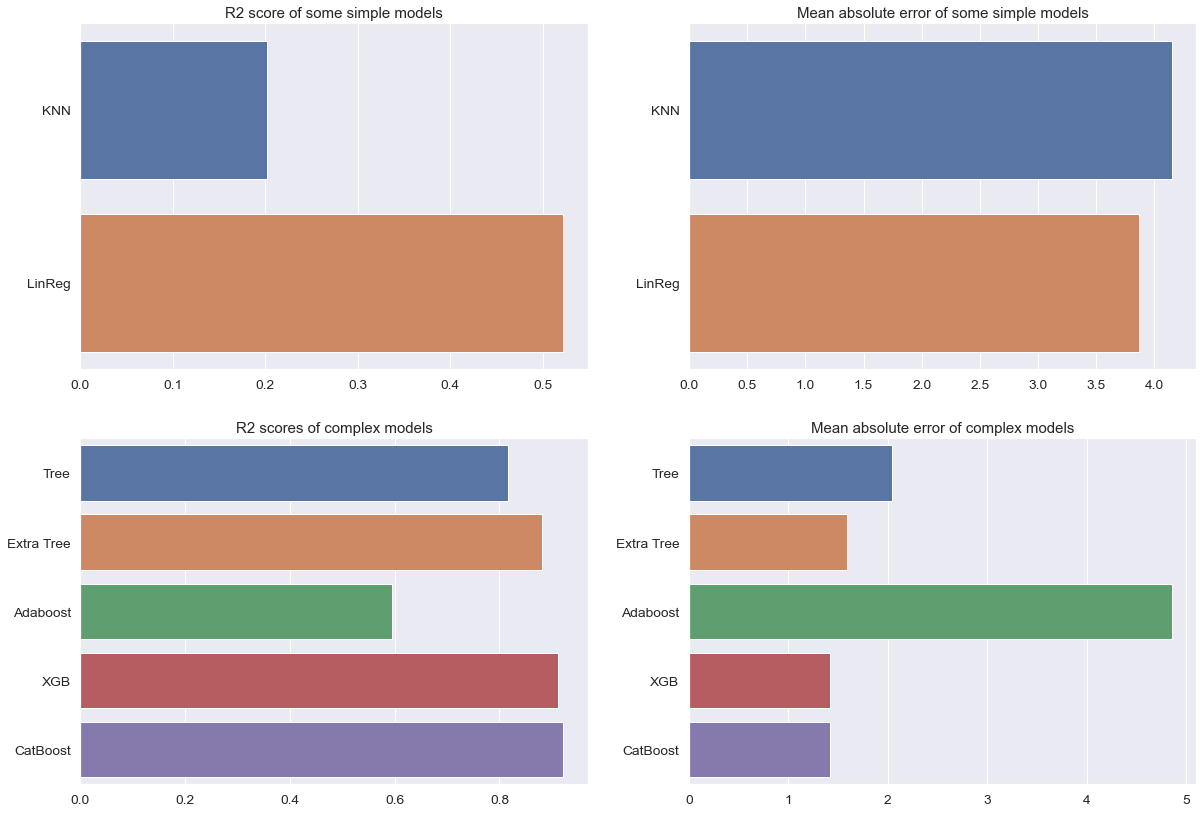

In [45]:
fig,ax=plt.subplots(2,2)
fig.set_figwidth(20)
fig.set_figheight(14)

basic_r2_scores=list()
basic_mean_scores=list()

for model in basic_models:
    model.fit(X_train,y_train)
    predictors=model.predict(X_val)
    print(predictors)
    basic_r2_scores.append(r2_score(predictors,y_val))
    basic_mean_scores.append(mean_absolute_error(predictors,y_val))
    
adv_r2_scores=list()
adv_mean_scores=list()

for model in adv_models:
    model.fit(X_train,y_train)
    predictors=model.predict(X_val)
    adv_r2_scores.append(r2_score(predictors,y_val))
    adv_mean_scores.append(mean_absolute_error(predictors,y_val))
    
sns.barplot(x=pd.Series(basic_r2_scores),y=pd.Series(basic_model_names),ax=ax[0,0])
ax[0,0].set_title("R2 score of some simple models")
sns.barplot(x=pd.Series(basic_mean_scores),y=pd.Series(basic_model_names),ax=ax[0,1])
ax[0,1].set_title("Mean absolute error of some simple models")

sns.barplot(x=pd.Series(adv_r2_scores),y=pd.Series(adv_model_names),ax=ax[1,0])
ax[1,0].set_title("R2 scores of complex models")
sns.barplot(x=pd.Series(adv_mean_scores),y=pd.Series(adv_model_names),ax=ax[1,1])
ax[1,1].set_title("Mean absolute error of complex models")
plt.show()

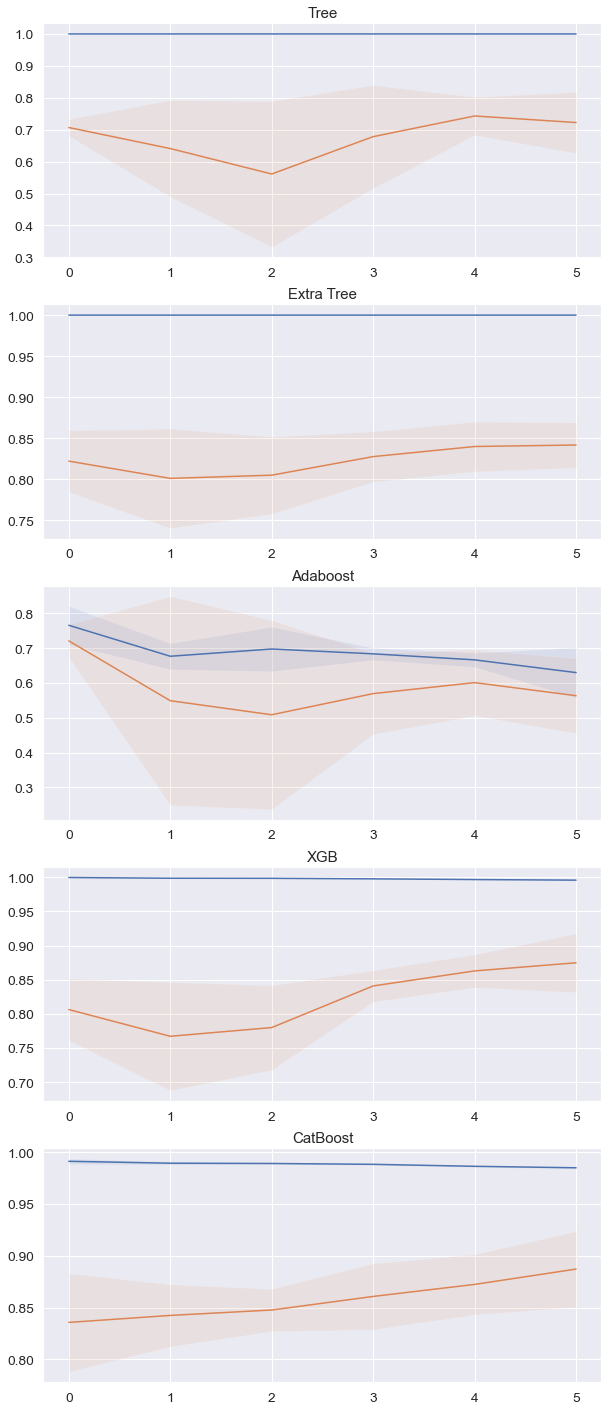

In [46]:
from sklearn.model_selection import learning_curve
fig,ax=plt.subplots(len(adv_models),figsize=[10,25])
i=0
train_sizes0=[0.2,0.4,0.5,0.6,0.8,1]
for model in adv_models:
    train_sizes,train_scores,val_scores=learning_curve(model,X,y,train_sizes=train_sizes0,cv=5,n_jobs=-1)
    train_scores=pd.DataFrame(train_scores).transpose()
    val_scores=pd.DataFrame(val_scores).transpose()

    min_train_scores=train_scores.mean()-train_scores.std()
    max_train_scores=train_scores.mean()+train_scores.std()

    min_val_scores=val_scores.mean()-val_scores.std()
    max_val_scores=val_scores.mean()+val_scores.std()


    ax[i].plot(train_scores.mean())
    ax[i].fill_between(range(len(train_scores.columns)),max_train_scores,min_train_scores,alpha=0.1)
    ax[i].plot(val_scores.mean())
    ax[i].fill_between(range(len(val_scores.columns)),max_val_scores,min_val_scores,alpha=0.1)
    ax[i].set_title(adv_model_names[i])
    i=i+1